In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [ # BASELINE on Regression ---- Comparison
                  (False, "run_20171001_11_05_13_metaV1_20ep_5ops_lr4e05"),  # 5 steps
                  (False, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"), # 50 steps
                  (False, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05"), # 100 steps
                  (False, "run_20171002_12_18_50_meta_actV1_50ep_tau0.0003_lr5e05"), # best M-ACT model
                  # M-PACT V3.2 model regression
                  (True, "run_20171003_13_58_38_act_sbV3.2_50ep_nu0.3kls1.0_lr5e05"),   # use - best 40epos 
                  (True, "run_20171003_12_09_31_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05"), # use  35 epos
                  (True, "run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05")  # use 30 epos
                  ]



In [4]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model act_sbV3.2_regression_nu0.3
INFO - INFO - loaded existing model from file logs/run_20171003_13_58_38_act_sbV3.2_50ep_nu0.3kls1.0_lr5e05/act_sbV3.2_regression_nu0.3.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']
INFO - created local logger for experiment with model act_sbV3.2_regression_nu0.5
INFO - INFO - loaded existing model from file logs/run_20171003_12_09_31_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/act_sbV3.2_regression_nu0.5.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.f

0 Loading model act_sbV3.2_regression_nu0.3 (q-prob 0.30) / run_20171003_13_58_38_act_sbV3.2_50ep_nu0.3kls1.0_lr5e05
1 Loading model act_sbV3.2_regression_nu0.5 (q-prob 0.50) / run_20171003_12_09_31_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05
2 Loading model act_sbV3.2_regression_nu0.9 (q-prob 0.90) / run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05


In [5]:
# del new_experiments
new_experiments = []
unrolled_steps=100
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171003_13_58_38_act_sbV3.2_50ep_nu0.3kls1.0_lr5e05 / path run_20171003_13_58_38_act_sbV3.2_50ep_nu0.3kls1.0_lr5e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171003_12_09_31_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05 / path run_20171003_12_09_31_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05 / path run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05/exp_eval_stats_10000_100steps.dll
Ready


In [4]:
with open("data/test_regression_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10reg_ALL_0_5.png


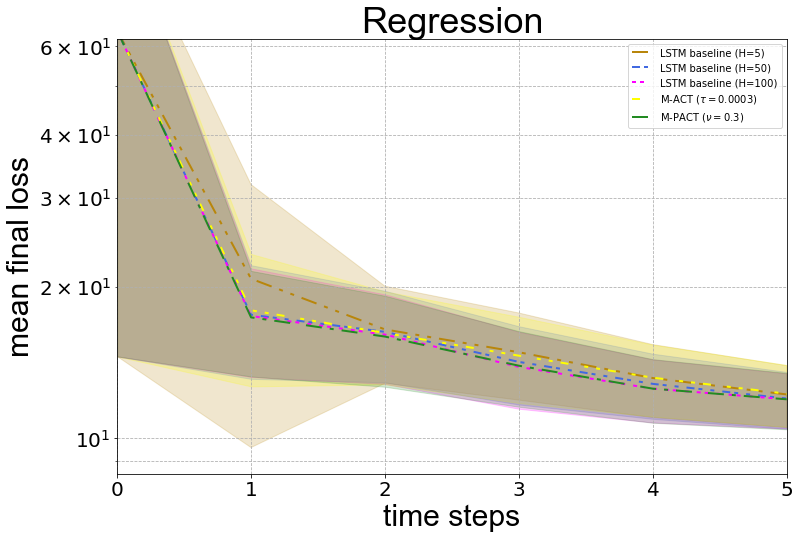

In [54]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 
part = 1
if part == 1:
    min_step = 0
    max_step = 5
    y_lim=[8.5, 62]
    log_scale  = True
elif part == 2:
    min_step = 4
    max_step = 100
    log_scale = True
    y_lim=[8.5, 12.5]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 62]
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10reg_ALL_" + str(min_step) + "_" + str(max_step), 
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [5]:
exp_idx = 0
model = models[exp_idx]

max_steps = 100
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV3.2_regression_nu0.2 with q-prob 0.200


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 64.415  17.339  15.882  13.865  12.437  11.961  11.883  11.841  11.518
  11.222  10.979  10.8    10.714  10.643  10.534  10.424  10.343  10.266
  10.209  10.162  10.113  10.059  10.018   9.985   9.949   9.92    9.898
   9.869   9.848   9.829   9.812   9.795   9.78    9.767   9.756   9.742
   9.735   9.727   9.716   9.709   9.705   9.694   9.689   9.686   9.677
   9.673   9.671   9.663   9.66    9.658   9.652   9.649   9.648   9.641
   9.641   9.639   9.633   9.633   9.632   9.625   9.626   9.625   9.618
   9.619   9.619   9.612   9.613   9.613   9.607   9.606   9.609   9.601
   9.602   9.603   9.596   9.596   9.598   9.591   9.591   9.593   9.587
   9.587   9.589   9.583   9.583   9.585   9.579   9.579   9.581   9.574
   9.575   9.577   9.571   9.571   9.573   9.567   9.568   9.569   9.564
   9.564   9.566]
INFO - ! - Validation last step 8 - !
INFO - Epoch: 400 - evaluation - halting step distribution
INFO - [   0    0 

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 3
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05/trajectory_weights_test_t0_9.png


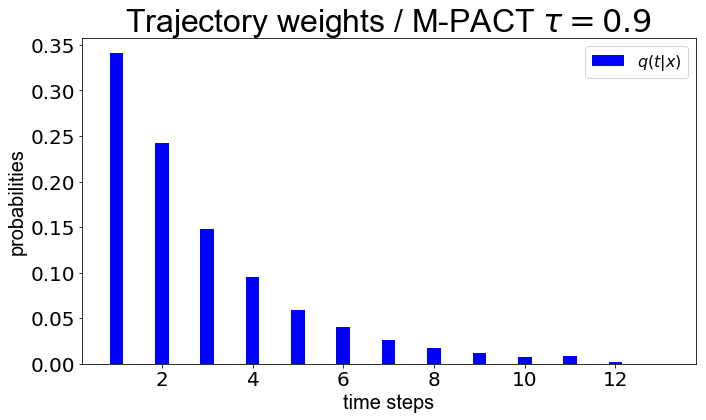

In [8]:
exper = new_experiments[2]
x_max = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_actsb_qts(exper, data_set="eval", save=True, show=True, add_info=False, epoch=400, 
              fig_name="trajectory_weights_test" + "_t{}".format(hyper_param), 
              huge=True,
              p_title=r"Trajectory weights / M-PACT $\tau={}$".format(exper.config.ptT_shape_param),
              height=6, width=11, x_max=x_max)

INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/test10000_halt_histogram.png


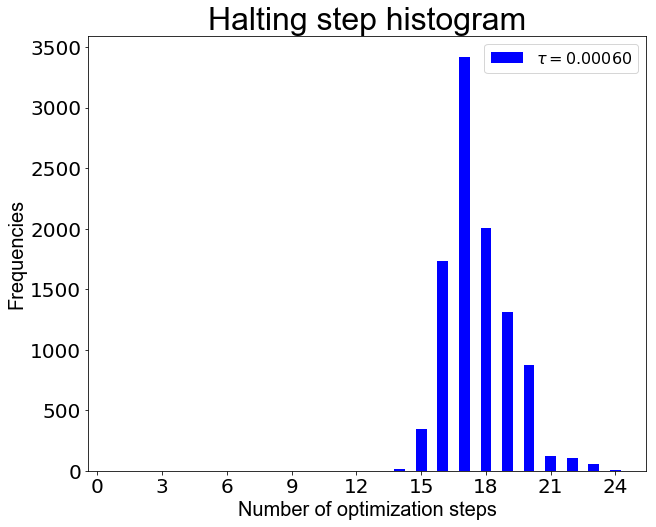

In [6]:
plot_dist_optimization_steps(new_experiments[0], data_set="eval", save=True, show=True, epoch=400, 
                            huge=True, xlimits=None, plot_title="Halting step histogram",
                            fig_name="test10000_halt_histogram")

INFO - Successfully saved fig logs/run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05/input_dependency_t0_9.png


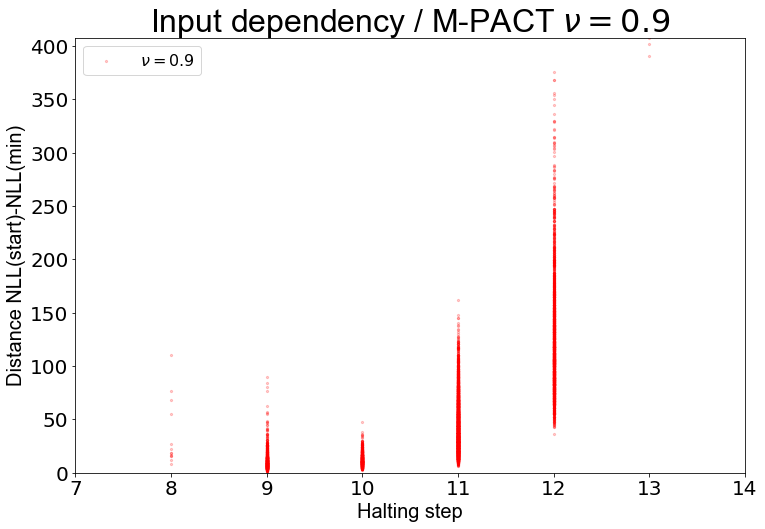

Mean 10.8909, Std 0.890054599449, Median 11, Total steps 108909


In [11]:

exper = new_experiments[2]
x_max = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_loss_versus_halting_step(exper, epoch=400, do_show=True, do_save=True, x_max=x_max,
                              p_title="Input dependency / M-PACT" + r" $\nu={}$".format(exper.config.ptT_shape_param), 
                              huge=True, log_scale=False,
                              fig_name="input_dependency" + "_t{}".format(hyper_param))

(101, 10)
INFO - Successfully saved fig logs/run_20171003_13_41_57_act_sbV3.2_50ep_nu0.9kls1.0_lr5e05/10dreg_mpact_st_losses_t0_9.png


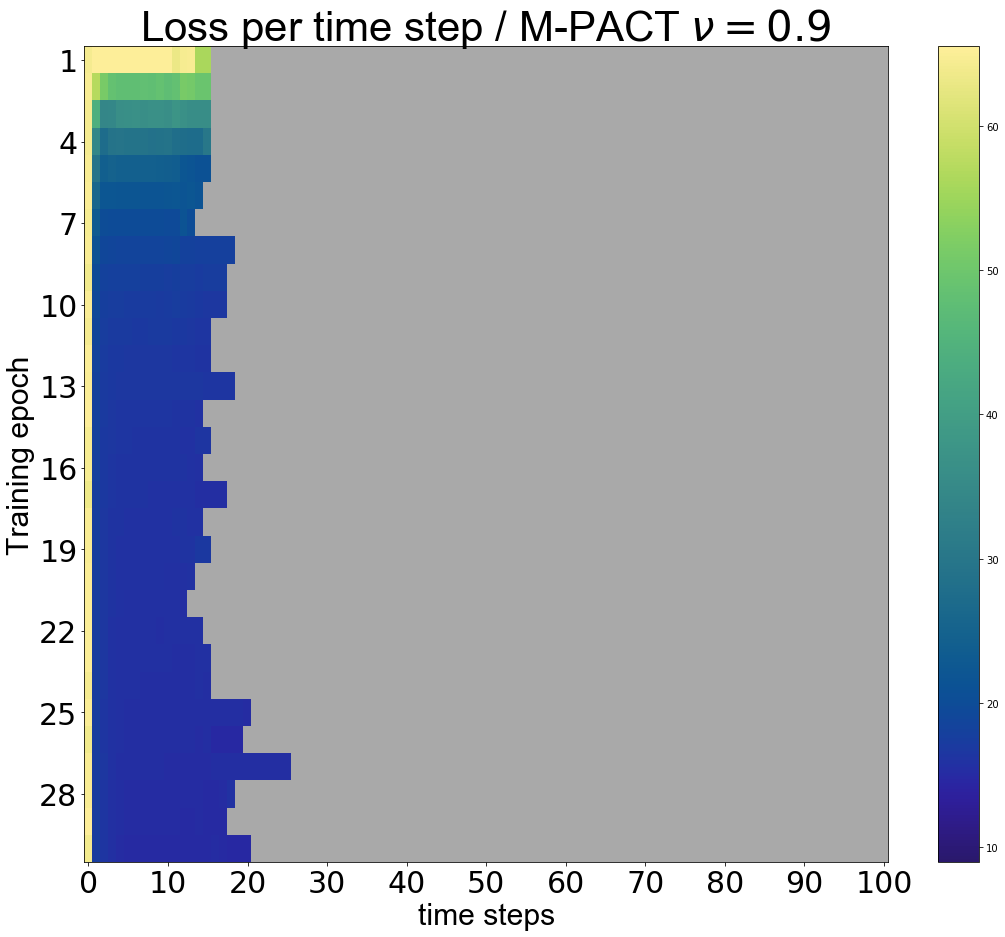

In [14]:

exper = experiments[2]
max_epoch = 30
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_image_map_losses(exper, fig_name="10dreg_mpact_st_losses" + "_t{}".format(hyper_param),
                      do_save=True, do_show=True, 
                      max_epoch=max_epoch, max_time_step=None, 
                      fig_title="Loss per time step / M-PACT" + r" $\nu={}$".format(exper.config.ptT_shape_param), 
                      scale= [18,60], huge=True)

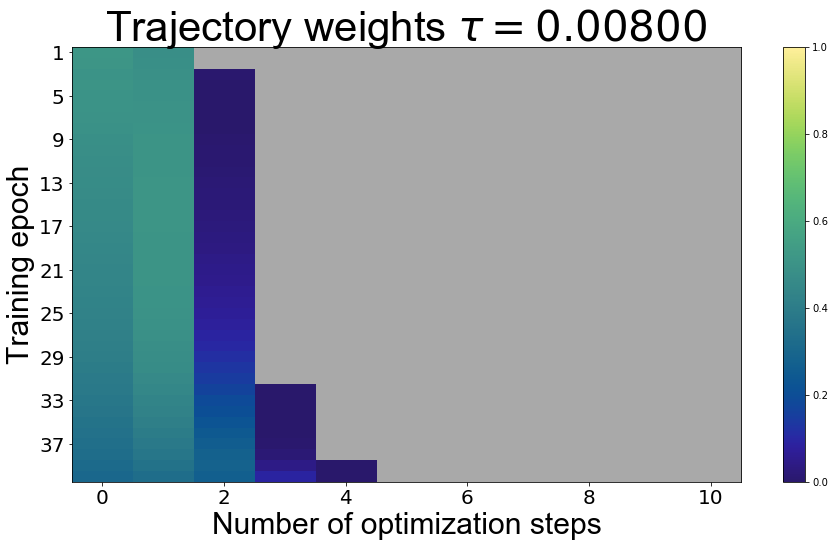

In [41]:
exper = experiments[0]
plot_image_map_data(exper, data_set="train",  width=15, height=8, do_save=False, do_show=True,
                        data="qt_value",  
                        max_epoch=None, max_time_step=11,
                        huge=True, 
                        plot_title="Trajectory weights" + r" $\tau={:.5f}$".format(exper.config.tau),
                        fig_name="trajectory_weights" + "_t{}".format(exper.config.tau))

In [32]:
expers_to_load = [# M-ACT V1 model regression
                  (True, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"),
                  (True, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05"),
                  (True, "run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05"),
                  (False, "run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05"),
                  ]

In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [29]:
def get_evaluation_step_loss(exper, steps=[1, 5, 50], epoch=None):
    if epoch is None:
        epoch = exper.val_stats["step_losses"].keys()[-1]
        
    step_losses = exper.val_stats["step_losses"][epoch]
    last_step = step_losses.shape[0] - 1
    # remember "step_losses" also incorporates the 0-step (initial loss), therefore we can easily
    # work with the real indices
    steps.extend([last_step])

    return step_losses[np.array(steps)]

def compute_total_steps(exper, epoch_range=None, is_train=True):

    if is_train:
        keys = exper.epoch_stats["halting_step"].keys()
        halt_dict = exper.epoch_stats["halting_step"]
    else:
        keys = exper.val_stats["halting_step"].keys()
        halt_dict = exper.val_stats["halting_step"]
    if epoch_range is None:
        epoch_range = [keys[0], keys[-1]]

    total_steps = 0
    for key, halting_steps in halt_dict.items():
        
        if epoch_range[0] <= key <= epoch_range[1]:
            num_of_steps = halting_steps.shape[0]
            values = np.arange(0, num_of_steps)
            total_steps += np.sum(values * halting_steps)

    return total_steps

total_ops = 0
idx = 1
exper = experiments[idx]
new_exper = new_experiments[idx]
print(exper.args.model)
if "act_sbV3.2" in exper.args.model:
    total_ops = compute_total_steps(exper, epoch_range=None)
step_losses = get_evaluation_step_loss(new_exper, steps=[1, 5, 30, 50])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses))

act_sbV3.2_regression_nu0.3
Total steps 1096420
Step losses
[ 17.37075424  11.94558525   9.80870056   9.63652229   9.52057457]


In [17]:
idx = 2
new_exper = new_experiments[idx]
print(new_exper.args.model)
mean, std, median, _ , a_range = new_exper.get_step_dist_statistics(with_range=True)
print("[{}, {}] & {:.2f} & {:.2f} & {} ".format(a_range[0], a_range[1], round(mean,2), round(std,2), median))

act_sbV3.2_regression_nu0.9
[8, 13] & 10.89 & 0.89 & 11 


In [36]:
experiments[5].generate_figures()

INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/loss_train_meta_actV1_50ep_tau0.0006.png
(100, 50)
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/loss_optimizer_train_meta_actV1_50ep_tau0.0006.png
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/loss_eval_meta_actV1_50ep_tau0.0006.png
(100, 50)
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/loss_optimizer_eval_meta_actV1_50ep_tau0.0006.png
(101, 10)
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/train_step_loss_map_meta_actV1_50ep_tau0.0006.png
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20171002_12_39_01_meta_actV1_50ep_tau0.0006_lr5e05/gradient_statistics.png
(101, 10)
INFO - Successfully saved fig logs/run_20171002_12_39_01_